**Imports**


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import os
import zipfile
import random 
import shutil
tfds.disable_progress_bar() 


Using TensorFlow backend.


Data set


In [ ]:
!git clone https://Jacob_Boesch@bitbucket.org/Jacob_Boesch/bird-classifer.git

Cloning into 'bird-classifer'...
remote: Counting objects: 14, done.
remote: Compressing objects: 100% (11/11), done.
tcmalloc: large alloc 1134977024 bytes == 0x55872454c000 @  0x7f90466a31e7 0x5586fa0667b5 0x5586fa06686d 0x5586f9f6727b 0x5586f9f67900 0x5586f9ee7a15 0x5586f9ee86d5 0x5586f9ee76da 0x7f90459eab97 0x5586f9ee772a
remote: Total 14 (delta 1), reused 0 (delta 0)
Unpacking objects: 100% (14/14), done.


In [ ]:
#TODO try combining the datasets
def extract_zip(file_name):
  path = '/content/bird-classifer'
  data_dir = os.path.join(path)
  zip_file = zipfile.ZipFile(data_dir + "/" + file_name, 'r')
  zip_file.extractall('/tmp/images')
  zip_file.close()

extract_zip("bird_dataset.zip")
extract_zip("bird_dataset_2.zip")


In [ ]:
data_dir = os.path.join('/tmp/images/images')
 

In [ ]:
# split the dataset into a validation dataset and a train dataset
VALIDATION_DATA_DIR = '/tmp/dataset/validation'
TRAIN_DATA_DIR = '/tmp/dataset/train'

def get_sub_folder_names(base_dir):
  sub_folders = os.listdir(base_dir)
  for folder in sub_folders:
    if(os.path.isdir(base_dir +"/" + folder) == False):
      sub_folders.remove(folder)
  return sub_folders

def create_sub_folders(base_dir, sub_folders):
  for folder in sub_folders:
    os.makedirs(base_dir + "/" + folder, exist_ok=True)


def copy_images(src_dir, train_image_dir, validation_image_dir, split):
  image_names = os.listdir(src_dir)
  num_images = len(image_names)
  random.shuffle(image_names)
  split_index = int(num_images * split)

  for i in range(0, split_index):
    image_file = src_dir + "/" + image_names[i]
    shutil.copy(image_file, train_image_dir + "/" + image_names[i])
  
  for j in range(split_index, num_images):
    image_file = src_dir + "/" + image_names[j]
    shutil.copy(image_file, validation_image_dir + "/" + image_names[j])
  

def split_dataset(directory, split):
  os.makedirs(VALIDATION_DATA_DIR,exist_ok=True)
  os.makedirs(TRAIN_DATA_DIR, exist_ok=True)
  sub_folders = get_sub_folder_names(directory)
  create_sub_folders(VALIDATION_DATA_DIR, sub_folders)
  create_sub_folders(TRAIN_DATA_DIR, sub_folders)

  for folder in sub_folders:
    copy_images(
        directory + "/" + folder,
        TRAIN_DATA_DIR + "/" + folder,
        VALIDATION_DATA_DIR + "/" + folder,
        split
    )


split_dataset(data_dir, .9)

In [ ]:
class_labels =  get_sub_folder_names(data_dir)
num_classes = len(class_labels)
print(num_classes)

200


In [ ]:
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE = 224 # using 224 x 224 because that's what the pretrained mobile net model uses 
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # use a 224 x 224 image with rgb for the color data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
) # set validation split

validation_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
) 

train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR, 
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
)

Found 1879 images belonging to 200 classes.
Found 15942 images belonging to 200 classes.


In [ ]:
#ALTERNATIVE MODEL
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               102600    
Total params: 3,016,456
Trainable params: 2,978,792
Non-trainable params: 37,664
_________________________________________________________________


In [ ]:
 from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0003, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
 callbacks = [EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=0, min_lr=0.0001), 
           ModelCheckpoint(filepath='bird_classifier_weights.h5', save_best_only=True)]


In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1, callbacks=callbacks)

Epoch 1/10
499/499 [==============================] - 214s 428ms/step - loss: 0.3937 - accuracy: 0.8911 - val_loss: 0.8749 - val_accuracy: 0.7541 - lr: 1.0000e-04
Epoch 2/10
499/499 [==============================] - 213s 428ms/step - loss: 0.3864 - accuracy: 0.8941 - val_loss: 0.8714 - val_accuracy: 0.7626 - lr: 1.0000e-04
Epoch 3/10
499/499 [==============================] - 213s 427ms/step - loss: 0.3783 - accuracy: 0.8976 - val_loss: 0.8652 - val_accuracy: 0.7578 - lr: 1.0000e-04
Epoch 4/10
499/499 [==============================] - 212s 426ms/step - loss: 0.3684 - accuracy: 0.9016 - val_loss: 0.8637 - val_accuracy: 0.7637 - lr: 1.0000e-04
Epoch 5/10
499/499 [==============================] - 213s 426ms/step - loss: 0.3577 - accuracy: 0.9008 - val_loss: 0.8805 - val_accuracy: 0.7547 - lr: 1.0000e-04
Epoch 6/10
499/499 [==============================] - 212s 425ms/step - loss: 0.3433 - accuracy: 0.9068 - val_loss: 0.8724 - val_accuracy: 0.7557 - lr: 1.0000e-04
Epoch 7/10
 15/499 [..

<Figure size 432x288 with 0 Axes>

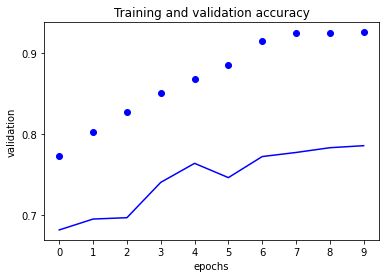

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.xlabel("epochs")
plt.ylabel("validation")
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0,1, .1))
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

### Save the labels to a file


In [ ]:
import random
import re
from keras.preprocessing import image
#TODO FIX THIS 
pattern = re.compile('.*\.jpg')

test_data = []
for label in get_sub_folder_names(VALIDATION_DATA_DIR):
  labeled_dir = os.path.join(VALIDATION_DATA_DIR + "/", label)
  list_of_images = os.listdir(labeled_dir)
  random.shuffle(list_of_images)
  image_name = list_of_images[0]
  if(pattern.match(image_name)):
    current_image_path = os.path.join(labeled_dir, image_name)
    img = image.load_img(current_image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image_data = image.img_to_array(img) 
    image_data = image_data /255
    image_data = np.expand_dims(image_data, axis=0)
    test_data.append((image_data, label))
  

In [ ]:
import re

for i in range(len(class_labels)):
    name = class_labels[i]
    name = re.sub("^\d+\.", "", name)
    name = re.sub("_", " ", name)
    class_labels[i] = name + '\n'

with open("labels.txt", 'wt') as labels_file:
    labels_file.writelines(class_labels)


### Optional manually test the model using an image of a dog from the internet



In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img) 
  x = x /255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=512)
  print(classes)
  index = np.argmax(classes)
  print("The image is: " + class_labels[index])


### Export the model to tflite

In [ ]:
BIRD_SAVED_MODEL = 'bird_classifier_saved_model'
tf.saved_model.save(model, BIRD_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: bird_classifier_saved_model/assets


INFO:tensorflow:Assets written to: bird_classifier_saved_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(BIRD_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert() 
tflite_model_file = 'bird_classifier_model.tflite'

with open(tflite_model_file, 'wb') as file:
  file.write(tflite_model)


### Test the TFLite Model Using the Python Interpreter

In [ ]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
print(input_index)
print(output_index)
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_data):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label)
    test_imgs.append(img)

  0%|          | 1/200 [00:00<00:22,  9.01it/s]

0
179


100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


In [ ]:
# visulize the results make sure they work using the tensorflow lite interpreter. 
# this part of the code came from the tensorflow lite course on coursera.
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                         100*np.max(predictions_array),
                                         class_labels[i]), color=color)


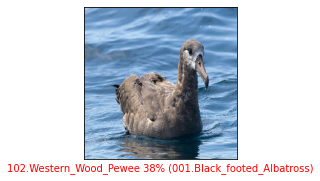

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 131 #@param {type:"slider", min:0, max:200, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

### Download the tflite file

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optional Download Test Images

In [ ]:
!mkdir -p test_images

from PIL import Image

for index, (image, label) in enumerate(test_batches.take(100)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.bmp'.format(label_names[label[0]], index))

!ls test_images
!zip -qq bird_test_images.zip -r test_images/

'affenpinscher'$'\n''_33.bmp'
'affenpinscher'$'\n''_33.jpg'
'afghan hound'$'\n''_21.bmp'
'afghan hound'$'\n''_21.jpg'
'afghan hound'$'\n''_37.bmp'
'afghan hound'$'\n''_37.jpg'
'afghan hound'$'\n''_7.bmp'
'afghan hound'$'\n''_7.jpg'
'airedale'$'\n''_27.bmp'
'airedale'$'\n''_27.jpg'
'airedale'$'\n''_32.bmp'
'airedale'$'\n''_32.jpg'
'australian terrier'$'\n''_95.bmp'
'australian terrier'$'\n''_95.jpg'
'basset'$'\n''_10.bmp'
'basset'$'\n''_10.jpg'
'beagle'$'\n''_18.bmp'
'beagle'$'\n''_18.jpg'
'beagle'$'\n''_65.bmp'
'beagle'$'\n''_65.jpg'
'beagle'$'\n''_93.bmp'
'beagle'$'\n''_93.jpg'
'bedlington terrier'$'\n''_26.bmp'
'bedlington terrier'$'\n''_26.jpg'
'bedlington terrier'$'\n''_82.bmp'
'bedlington terrier'$'\n''_82.jpg'
'bernese mountain dog'$'\n''_4.bmp'
'bernese mountain dog'$'\n''_4.jpg'
'black-and-tan coonhound'$'\n''_76.bmp'
'black-and-tan coonhound'$'\n''_76.jpg'
'bloodhound'$'\n''_3.bmp'
'bloodhound'$'\n''_3.jpg'
'bluetick'$'\n''_71.bmp'
'bluetick'$'\n''_71.jpg'
'bluetick'$'\n''_90.

In [ ]:
from google.colab import files
try:
    files.download('bird_test_images.zip')
except:
  
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>